In [778]:
import numpy as np
import numpy.random as rnd
import time


def extend( A ):

    A = np.hstack(
        (A, np.zeros( (A.shape[0],1) ))
    ); A = np.vstack(
        (A, np.array( (0.0,)*(A.shape[1]-1) + (1.0,), ndmin=2 ))
    )

    return A


def downdateEx( A ):

    p = A.shape[ 0 ]
    q = A.shape[ 1 ]
    r = min( p, q )

    D = A[ :, -1 ]; D = D.reshape( p, 1 )

    # retrieve a first SVD representation
    U, s, Vt = np.linalg.svd( A, full_matrices=False )

    Q1, R1 = np.linalg.qr( 
        np.dot(
            np.dot( U, U.T ) - np.identity( p ),
            D
        )
    )

    Q2, R2 = np.linalg.qr(
        np.dot(
            np.identity( q ) - np.dot( Vt.T, Vt ),
            np.vstack(
                (np.zeros( (q-D.shape[1], D.shape[1] ) ),
                np.identity( D.shape[1] ))
            )
        )
    )

    l = D.shape[ 1 ]

    Q1p = Q1[ :, :l ]
    Q2p = Q2[ :, :l ]

    R1p = R1[ :l, : ]
    R2p = R2[ :l, : ]


    K = np.dot(

        np.vstack((
            -np.dot( U.T, D ),
            R1p
        )),

        np.hstack((
            np.dot(
                np.hstack((
                    np.zeros(( l, q-l )),
                    np.identity( l )
                )),
                Vt.T
            ),
            np.transpose( R2p )
        ))

    )

    K = K + np.diag( np.append( s, 0 ) )

    Uk, sk, Vtk = np.linalg.svd( K, full_matrices=False )


    Ud = np.dot(
        np.hstack((
            U,
            Q1p
        )),
        Uk
    )

    sd = sk
    sd[ abs( sd ) < 1.0e-10 ] = 0

    Vd = np.dot(
        np.hstack((
            Vt.T, Q2p
        )),
        Vtk.T
    )

    Vd = Vd[ :q-l, : ]
    Vdt = np.transpose( Vd )

    
    nm = Ud.shape[ 0 ]
    nn = Vdt.shape[ 1 ]
    nr = min( nm, nn )

    Ud = Ud[ :, :nr ]
    sd = sd[ :nr ]
    Vdt = Vdt[ :nr, : ]
    
    
    return Ud, sd, Vdt



class iSVD( object ):

    def __init__( self, inU, ins, inVt, updateVt = False ):

        self.m, self.n = inU.shape[ 0 ], inVt.shape[ 1 ]
        self.U, self.iU, self.s, self.iVt, self.Vt = inU, None, ins, None, inVt

        self.iVpsinv = None
        self.updateVt = updateVt

        
        
    def update( self, data ):
        
        a = data.reshape( data.shape[0], )
                
        # m = {U^T} a / m = U'^T {U^T} a (if U' is defined)
        mv = np.dot( self.U.T, a )
        if not self.iU is None:
            mv = np.dot( self.iU.T, mv )
        
        
        # assuming the rank does not increase, verifying below
        rankIncreasingUpdate = False
        
        if self.n < self.m:
            
            # p = a - Um / p = a - U U'm (if U' is defined)
            if self.iU is None:
                p = a - np.dot( self.U, mv )
            else:
                p = a -  np.dot( self.U, np.dot( self.iU, mv ) )
            
            # Ra = \| p \|_{2}
            Ra = np.linalg.norm( p, ord = 2 )
            
            # verify if the column is from the same subspace
            epsilon = np.sqrt( np.finfo(np.float64).eps * self.m**2 * self.n * 10*2 )                        
            if ( np.abs( Ra ) > epsilon ):
                rankIncreasingUpdate = True
        
        
        if rankIncreasingUpdate == False:

            # construct svd-decomposition (update s directly)
            C, self.s, Dt = self.diagUpdate( self.s, mv, column=False )

            # U' = C / U' = U'C (if U' is defined)
            if self.iU is None:
                self.iU = C
            else:
                self.iU = np.dot( self.iU, C )

            # if it was specified that V^T should be updated
            if self.updateVt:
                                
                r = Dt.shape[ 1 ]
                W = Dt[ 0:r, : ]
                w = Dt[ r, : ]; w.shape = ( 1, w.shape[0] )
                
                # \|w\|^2 - squared norm
                wnrmsq = np.linalg.norm( w, ord=2 )**2
                # W^{+} = W^T + \frac{ w^T }{ 1-\|w\|^2 }\(wW^T\)
                Wpsinv = W.T + np.dot( (1/(1-wnrmsq))*w.T, np.dot( w, W.T ) )
                del r, wnrmsq

                # V'_{new} = V'_{old} W (note: using the transposes below which,
                # in turn, gives the following form: V'^T_{new} = W^T V'^T_{old}
                if not self.iVt is None:
                    self.iVt = np.dot( W.T, self.iVt )
                else:
                    self.iVt = W.T

                # (V'^{+})_{new} = W^{+} (V'^{+})_{old}
                if not self.iVpsinv is None:
                    self.iVpsinv = np.dot( Wpsinv, self.iVpsinv )
                else:
                    self.iVpsinv = Wpsinv

                # V_{new} = \begin{bmatrix} V_{old} \\ w(V'^{+})_{new} \end{bmatrix}
                self.Vt = np.hstack( (self.Vt, np.dot( self.iVpsinv.T, w.T) ) )

                del w, Wpsinv, W
        
        if rankIncreasingUpdate == True:
        
            # adding a trailing 0 (0 column and a 0 row via diag.)
            S = np.concatenate( ( self.s, (0.0,) ) )
            mv = np.concatenate( ( mv, (Ra,) ) )

            C, self.s, Dt = self.diagUpdate( S, mv, column=True)

            self.U = np.hstack( (self.U, p[ :, np.newaxis ] / Ra) )
        
            if self.iU is None:
                self.iU = C
            else:
                self.iU = extend( self.iU )
                self.iU = np.dot( self.iU, C )

                
            if self.updateVt:
                self.Vt = extend( self.Vt )
                if not self.iVt is None:
                    self.iVt = np.dot( Dt.T, extend(self.iVt) )
                else:
                    self.iVt = Dt.T

                if not self.iVpsinv is None:
                    self.iVpsinv = np.dot( Dt.T, extend( self.iVpsinv ) )
                else:
                    self.iVpsinv = Dt.T
        
        self.n = self.Vt.shape[ 1 ]



    def downdate( self, k ):
        
        Ux, sx, Vtx = self.svd()
        A = np.dot( Ux, np.dot( np.diag(sx), Vtx ) )
        
        Af = A.copy()
        Af[ :, :Af.shape[1]-1 ] = A[ :, 1: ]
        
        self.U, self.s, self.Vt = downdateEx( Af )        

        self.iVpsinv = None
        
        self.iU = None
        self.iVt = None
        
        self.iVpsinv = None        
        self.n = self.Vt.shape[ 1 ]        
        
        

    def diagUpdate( self, sigmas, mv, column = True ):

        if column == False:

            nv = np.copy( mv )
            nv = nv.reshape( nv.shape[ 0 ], 1 )

            K = np.hstack( ( np.diag( sigmas ), nv  ) )
        else:

            K = np.diag( sigmas )
            K[ :, -1 ] = mv

        Ux, sx, Vtx = np.linalg.svd( K, full_matrices=False )
        return Ux, sx, Vtx.T
        

    def svd( self ):

        if not self.iU is None:
            Ux = np.dot( self.U, self.iU )
        else:
            Ux = self.U

        if self.updateVt:
            if not self.iVt is None:
                Vtx = np.dot( self.iVt, self.Vt )
            else:
                Vtx = self.Vt
        else:
            Vtx = None

        return Ux, self.s.copy(), Vtx

    
    
    def esvd( self ):
        return self.U, self.iU, self.s, self.iVt, self.Vt
    
    

    def orthogonalize( self ):

        if not self.iU is None:
            
            Usvd, ssvd, Vsvd = np.linalg.svd( 
                np.dot( self.iU, np.diag( self.s ) ), full_matrices=False, compute_uv=True 
            )

            self.U = np.dot( self.U, Usvd ); self.iU = None
            self.s = ssvd

            if self.updateVt:                
                
                self.Vt = np.dot( np.dot( Vsvd, self.iVt), self.Vt )
                self.iVt = None; self.iVpsinv = None
                
                return self.U, self.s, self.Vt
            else:
                return self.U, self.s, None
        else:
            pass

In [773]:
def test_SVD_updater():
    """
    Testinf function for iSVD class.
    """

    increaseRank = False

    if increaseRank:
    
        # Test column update. Thin matrix, rank increases
        n_rows = 1000; n_cols = 800
        A = rnd.rand(n_rows,n_cols)
        (U,S,Vh) = np.linalg.svd( A , full_matrices=False, compute_uv=True )
        
        a1 = rnd.rand(n_rows,1)
        A = np.hstack( (A,a1) )
        (Ut1,St1,Vht1) = np.linalg.svd( A  , full_matrices=False, compute_uv=True)

        print ( "START TEST 1 -------------------------------" );
        SVD_upd = iSVD( U,S,Vh, updateVt = True)        

        SVD_upd.update(a1 )
        (Us1, Ss1, Vhs1) = SVD_upd.svd()

        
        

        
        Ar1 = np.dot( Us1, np.dot(np.diag(Ss1), Vhs1 ) )
        print ( "END TEST 1 -------------------------------" );        
        diff1 = np.max( np.abs( A - Ar1) )/St1[0]
        print( np.allclose( A, Ar1 ) )
        
        a2 = rnd.rand(n_rows,1)
        A = np.hstack( (A,a2) )
        
        print ( "START TEST 2 -------------------------------" );
        SVD_upd.update( a2 )
        (Us2, Ss2, Vhs2) = SVD_upd.svd()
        
        Ar2 = np.dot( Us2, np.dot(np.diag(Ss2), Vhs2 ) )
        print ( "END TEST 2 -------------------------------" );
        diff2 = np.max( np.abs( A - Ar2) )/St1[0]
        print( np.allclose( A, Ar2 ) )
        
    else:

        #Test column update. Thin matrix, rank not increases
        n_rows = 1000; n_cols = 800
        A = rnd.rand(n_rows,n_cols)
        (U,S,Vh) = np.linalg.svd( A , full_matrices=False, compute_uv=True )
        
        ##a1 = rnd.rand(5,1)
        a1 = np.dot(A, rnd.rand(n_cols,1) )
        A = np.hstack( (A,a1) )
        (Ut,St,Vht) = np.linalg.svd( A  , full_matrices=False, compute_uv=True)
        

        print ( "START TEST 1 -------------------------------" );
        SVD_upd = iSVD( U,S,Vh, updateVt = True)
        SVD_upd.update( a1 )
        ( Us1, Ss1, Vhs1) = SVD_upd.svd()

        Ar1 = np.dot( Us1, np.dot(np.diag(Ss1), Vhs1 ) )
        
        diff1 = np.max( np.abs( A - Ar1) )/St[0]
        print ( "END TEST 1 -------------------------------" );
        print( np.allclose( A, Ar1 ) )

        
        
        print ( "START TEST 2 -------------------------------" );
        a2 = rnd.rand(n_rows,1)
        
        #a2 = np.dot(A, np.array([2,1,4,-3],ndmin=2 ).T )
        A = np.hstack( (A,a2) )
        (Ut,St,Vht) = np.linalg.svd( A  , full_matrices=False, compute_uv=True)
        SVD_upd.update( a2 )
        (Us2, Ss2, Vhs2) = SVD_upd.svd()

        
        Ar2 = np.dot( Us2, np.dot(np.diag(Ss2), Vhs2 ) )
        print ( "END TEST 2 -------------------------------" );        
        print( np.allclose( A, Ar2 ) )
        
        diff2 = np.max( np.abs( A - Ar2) )/St[0]

    print( diff2 )
    return diff2

test_SVD_updater()

START TEST 1 -------------------------------
END TEST 1 -------------------------------
True
START TEST 2 -------------------------------
END TEST 2 -------------------------------
True
6.4656418839931906e-15


6.4656418839931906e-15

In [774]:
p = 50; q = 100;
r = min( p, q )

# construct a random matrix of size m, n
#X = np.random.randn( p, q ) + 1j*np.random.randn( p, q )
X = np.random.randn( p, q )

U, S, Vh = np.linalg.svd( X, full_matrices=False )

isvd = iSVD( U, S, Vh, updateVt = True  )

# construct a random update vector
#a = np.random.randn( p, 1 ) + 1j*np.random.randn( p, 1 )
a = np.random.randn( p, 1 )

isvd.update( a )
(Un, Sn, Vhn ) = isvd.svd()

In [775]:
b = np.zeros( (q+1,1) ); b[ q ] = 1
Aab = np.append( X, np.zeros( (p,1), dtype=complex), axis=1  ) + np.dot( a, np.transpose(b) )

X = Aab

Sp = np.diag( isvd.s )
Ai = np.dot( Un, np.dot(np.diag(Sn), Vhn ) )


Aix = np.dot( isvd.U, isvd.iU)
Aix = np.dot( Aix, np.diag(isvd.s) )
Aix = np.dot( Aix, np.dot(isvd.iVt, isvd.Vt) )

print( Aab.shape,Ai.shape )
print( np.allclose( Aab, Ai ) )
print( np.allclose( Aab, Aix ) )


q = q-2
Aab = Aab[ :, 1: ]
isvd.downdate( 0 )
Aab = Aab[ :, 1: ]
isvd.downdate( 0 )

# Aix = np.dot( isvd.U, isvd.iU)
# Aix = np.dot( Aix, np.diag(isvd.s) )
# Aix = np.dot( Aix, np.dot(isvd.iVt, isvd.Vt) )

Aix = np.dot( isvd.U, np.dot( np.diag( isvd.s ), isvd.Vt ))

print( np.allclose( Aab, Aix ) )

(50, 101) (50, 101)
True
True
True


In [108]:
import time

t0a = time.time()


for i in range(0, 300 ):
    
    a = np.random.randn( p, 1 )

    
    t0i = time.time()
    isvd.update( a )
    
    (Un, Sn, Vhn ) = (None, None, None)
    if (isvd.iU is None) or (isvd.iVt is None):
        Un, Sn, Vhn = isvd.svd()
    t1i = time.time()

    
    q = q+1

    b = np.zeros( (q+1,1) ); b[ q ] = 1
    Aab = np.append( Aab, np.zeros( (p,1), dtype=complex), axis=1  ) + np.dot( a, np.transpose(b) )

    
    t0 = time.time()
    Uab, sab, Vtab = np.linalg.svd( Aab, full_matrices=False )
    t1 = time.time()

    
    similar = True
    
    print( "Current index: ", i)
    print( "Incremental: ", (t1i-t0i), " Regular: ", (t1-t0))
    print( "Shape: ", Aab.shape )

    if not Un is None:
        Ai = np.dot( Un, np.dot( np.diag(Sn), Vhn ) )
        
        if np.allclose( Aab, Ai ) == False:
            similar = False
        print( "Aab vs Ai: ", similar )

    if Un is None:
        Aix = np.dot( isvd.U, isvd.iU)
        Aix = np.dot( Aix, np.diag(isvd.s) )
        Aix = np.dot( Aix, np.dot(isvd.iVt, isvd.Vt) )

        if np.allclose( Aab, Aix ) == False:
            similar = False
        print( "Aab vs Aix: ", similar )
    print( "---------------------------------\n" )
    
    if i % 100 == 0:
        t1a = time.time()
        print( "Iteration: ", i, Aab.shape, " ", (t1a-t0a), "s" )
        
        if Un is None:
            print( "        ", isvd.U.shape, isvd.iU.shape, isvd.s.shape, isvd.iVt.shape, isvd.Vt.shape, "\n" )

            
    if i > 0 and i % 5 == 0 and np.random.randn(1) < 0.5:
        isvd.downdate( 0 )
        Aab = Aab[ :, 1: ]

        q = q-1 
        
        (Un, Sn, Vhn ) = (None, None, None)
        if (isvd.iU is None) or (isvd.iVt is None):
            Un, Sn, Vhn = isvd.svd()
        
        if not Un is None:
            Ai = np.dot( Un, np.dot( np.diag(Sn), Vhn ) )

            if np.allclose( Aab, Ai ) == False:
                similar = False
            print( "DOWNDATE Aab vs Ai: ", similar )

        if Un is None:
            Aix = np.dot( isvd.U, isvd.iU)
            Aix = np.dot( Aix, np.diag(isvd.s) )
            Aix = np.dot( Aix, np.dot(isvd.iVt, isvd.Vt) )

            if np.allclose( Aab, Aix ) == False:
                similar = False
            print( "DOWNDATE Aab vs Aix: ", similar )
            
            
            
    if similar == False:
        print( "Current index: ", i)
        print( "Shape: ", Aab.shape )
        
        print( (((Aab - Aix) **2) **0.5).mean() )
        
        break;

        
t1a = time.time()
print( "Overall time: ", (t1a-t0a) )

Current index:  0
Incremental:  0.0008389949798583984  Regular:  0.0031409263610839844
Shape:  (50, 100)
Aab vs Aix:  True
---------------------------------

Iteration:  0 (50, 100)   0.005399227142333984 s
         (50, 50) (50, 50) (50,) (50, 50) (50, 100) 

Current index:  1
Incremental:  0.000988006591796875  Regular:  0.0021996498107910156
Shape:  (50, 101)
Aab vs Aix:  True
---------------------------------

Current index:  2
Incremental:  0.001033782958984375  Regular:  0.002145051956176758
Shape:  (50, 102)
Aab vs Aix:  True
---------------------------------

Current index:  3
Incremental:  0.00096893310546875  Regular:  0.0028061866760253906
Shape:  (50, 103)
Aab vs Aix:  True
---------------------------------

Current index:  4
Incremental:  0.0009598731994628906  Regular:  0.0021550655364990234
Shape:  (50, 104)
Aab vs Aix:  True
---------------------------------

Current index:  5
Incremental:  0.0010149478912353516  Regular:  0.0028007030487060547
Shape:  (50, 105)
Aab vs 

Current index:  79
Incremental:  0.0011768341064453125  Regular:  0.0034780502319335938
Shape:  (50, 169)
Aab vs Aix:  True
---------------------------------

Current index:  80
Incremental:  0.0014581680297851562  Regular:  0.0036928653717041016
Shape:  (50, 170)
Aab vs Aix:  True
---------------------------------

DOWNDATE Aab vs Ai:  True
Current index:  81
Incremental:  0.0013308525085449219  Regular:  0.0029990673065185547
Shape:  (50, 170)
Aab vs Aix:  True
---------------------------------

Current index:  82
Incremental:  0.0013780593872070312  Regular:  0.0028717517852783203
Shape:  (50, 171)
Aab vs Aix:  True
---------------------------------

Current index:  83
Incremental:  0.0012898445129394531  Regular:  0.0035858154296875
Shape:  (50, 172)
Aab vs Aix:  True
---------------------------------

Current index:  84
Incremental:  0.0011091232299804688  Regular:  0.0030651092529296875
Shape:  (50, 173)
Aab vs Aix:  True
---------------------------------

Current index:  85
Incr

Current index:  138
Incremental:  0.0012140274047851562  Regular:  0.004071950912475586
Shape:  (50, 221)
Aab vs Aix:  True
---------------------------------

Current index:  139
Incremental:  0.0011281967163085938  Regular:  0.0031969547271728516
Shape:  (50, 222)
Aab vs Aix:  True
---------------------------------

Current index:  140
Incremental:  0.001251220703125  Regular:  0.003936052322387695
Shape:  (50, 223)
Aab vs Aix:  True
---------------------------------

Current index:  141
Incremental:  0.0020301342010498047  Regular:  0.003371000289916992
Shape:  (50, 224)
Aab vs Aix:  True
---------------------------------

Current index:  142
Incremental:  0.0011477470397949219  Regular:  0.0031228065490722656
Shape:  (50, 225)
Aab vs Aix:  True
---------------------------------

Current index:  143
Incremental:  0.0010759830474853516  Regular:  0.003900289535522461
Shape:  (50, 226)
Aab vs Aix:  True
---------------------------------

Current index:  144
Incremental:  0.001142978668

Incremental:  0.0015628337860107422  Regular:  0.005189180374145508
Shape:  (50, 267)
Aab vs Aix:  True
---------------------------------

Current index:  193
Incremental:  0.0013399124145507812  Regular:  0.004724979400634766
Shape:  (50, 268)
Aab vs Aix:  True
---------------------------------

Current index:  194
Incremental:  0.00131988525390625  Regular:  0.00510716438293457
Shape:  (50, 269)
Aab vs Aix:  True
---------------------------------

Current index:  195
Incremental:  0.0012640953063964844  Regular:  0.004204988479614258
Shape:  (50, 270)
Aab vs Aix:  True
---------------------------------

Current index:  196
Incremental:  0.0012569427490234375  Regular:  0.004068851470947266
Shape:  (50, 271)
Aab vs Aix:  True
---------------------------------

Current index:  197
Incremental:  0.001435995101928711  Regular:  0.004606008529663086
Shape:  (50, 272)
Aab vs Aix:  True
---------------------------------

Current index:  198
Incremental:  0.0011830329895019531  Regular:  0.0

Current index:  244
Incremental:  0.0012276172637939453  Regular:  0.0050201416015625
Shape:  (50, 315)
Aab vs Aix:  True
---------------------------------

Current index:  245
Incremental:  0.0014438629150390625  Regular:  0.004342079162597656
Shape:  (50, 316)
Aab vs Aix:  True
---------------------------------

DOWNDATE Aab vs Ai:  True
Current index:  246
Incremental:  0.0012030601501464844  Regular:  0.0044400691986083984
Shape:  (50, 316)
Aab vs Aix:  True
---------------------------------

Current index:  247
Incremental:  0.0014011859893798828  Regular:  0.004281759262084961
Shape:  (50, 317)
Aab vs Aix:  True
---------------------------------

Current index:  248
Incremental:  0.0013129711151123047  Regular:  0.0042247772216796875
Shape:  (50, 318)
Aab vs Aix:  True
---------------------------------

Current index:  249
Incremental:  0.0012161731719970703  Regular:  0.0041768550872802734
Shape:  (50, 319)
Aab vs Aix:  True
---------------------------------

Current index:  250

Nb of samples: 986 ( 64 samples used for training )
Time: 0.0825200080871582 ( 0.00347137451171875 for training )
RMSE: 0.07963598254201146


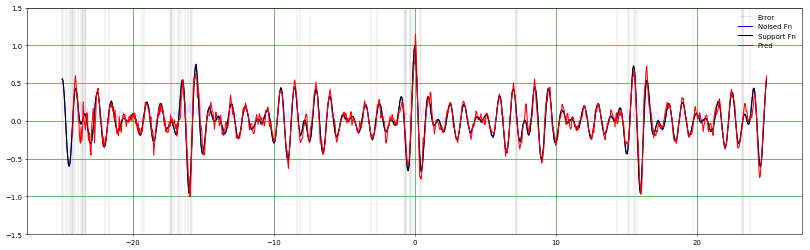

In [792]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import arange, pi

%matplotlib inline 


# function range and actual values
t = arange( -25.0, 25.0, 0.05 )

fnA = np.cos( 2*pi*t ) * np.exp( -1.5*np.abs( np.abs( np.sin( 0.125*pi*t )) ) ) * np.cos( np.abs(t) )
fnB = np.cos( 1.0e-1*pi*t )

# single point of switching mix function (sigmoidal)
mixfnA = 1.0/(1.0+np.exp( -t ))
# multiple alternating switching points (sinusoid) 
mixfnB = (1+np.sin( 0.1*pi*t))/2
# first function ONLY (second function NOT used)
mixfnC = 1-t**0
# second function ONLY (first function NOT used)
mixfnD = t**0
# increasingly fast switching between the two functions
mixfnE = np.sin( 2*pi*(1e-1*t)**2 )

mixfn = mixfnE*(1-mixfnE)*mixfnA*(1-mixfnA)*mixfnE*(1-mixfnB)

fn = (1-mixfn)*fnA + mixfn*fnB



# variance for a normal noise applied to the function
sigma = 1.0e-2
# noised function (normal noise with sigma as specified above)
nfn = fn + sigma*np.random.randn( t.shape[ 0 ], )




# if running in 'adaptive' mode, a sample is used to update the model
# only if the absolute prediction error is above a specified threshold
adaptive = True
errorThreshold = 1.0e-1
# if adaptive mode is 'false' then a percentage of the samples is used
# for training (first percentage * nbSamples, cf. window 'scanner' below)
percentageTraining = 2.5e-1

# response values, actual vs predicted (lresp is for the learnt samples/responses)
resp = []; xresp = []; lresp = [];
# index of the samples that were used as input for learning
lsindx = []



# index and size of the window we will use to scan the data; response offset w.r.t. window
indx = 0; windowSize = 10; respOffset = 1; nbRespValues = 5; maxModelSamples = 150



# number of hidden units (rough ann simulation)
nbHUnits = 15
# initialize a matrix of randow weights (input-hidden layer)
rweights = np.random.randn( windowSize, nbHUnits )
# output weights (that need to be determined, first random)
oweights = np.random.randn( nbHUnits, nbRespValues )



# ann svd for the output layer
annisvd = None



# counters and basic information (time spent training, nb. of samples, etc.)
startt = time.time()

trainingTime = 0
nbTrainingSamples = 0
nbSamples = 0

sampleData = None
sampleDataResponse = None

while indx < t.shape[ 0 ] - (windowSize + respOffset-1 + nbRespValues-1 ):
        
    hlinp = np.dot( nfn[ indx:windowSize+indx ], rweights )
    hlinp = 1.0/( 1.0 + np.exp( -0.1*hlinp ) ) - 0.5
    
    # store the actual response and calculate the predicted response values
    aresponse = nfn[ indx + (windowSize + respOffset-1) : indx + (windowSize + respOffset-1 + nbRespValues) ]
    presponse = np.dot( hlinp.reshape( 1, nbHUnits ), oweights ).reshape( nbRespValues, )
    
    error = ( np.sum((presponse-aresponse)**2) / nbRespValues )**0.5
    
    xresp = np.append( xresp, presponse[ -1 ] )
    resp  = np.append( resp, aresponse[ -1 ] )
    
    
    if sampleData is None:
        sampleData = nfn[ indx:windowSize+indx ]
        sampleDataResponse = aresponse
    else:
        sampleData = np.vstack( (sampleData, nfn[ indx:windowSize+indx ]) )
        sampleDataResponse = np.vstack( (sampleDataResponse, aresponse) )

            
    # no svd has been computed up to now, no prediction can be made
    if annisvd == None:
        X = hlinp.reshape( nbHUnits, 1 )
        U, s, Vt = np.linalg.svd( X, full_matrices=False )
        
        annisvd = iSVD( U, s, Vt, updateVt = True  )        
        lresp = [ aresponse ]
        sampleAdded = True
        
    else:
        
        if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold):
            annisvd.update( hlinp.reshape( nbHUnits, 1 ) )
            lresp = np.vstack( (lresp, aresponse) )                    
            
            if annisvd.Vt.shape[ 1 ] > maxModelSamples:
                annisvd.downdate( 0 )
                lresp = lresp[ 1:, : ]

            
    # updating the output weights - note that the update method adds columns
    # and NOT rows (as it would be expected for Ax = y); the incremental SVD
    # we obtain is thus for A^T - we need however the A^+ (pseudoeinverse of A)
    
    # if A^T = UsV^T (SVD) and knowing that i. (A^T)+ = Vs^{-1}U^T; and (ii) (A^+)^T = (A^T)^+
    # we have that (A^+)^T = Vs^{-1}U^T, following that A^+ = Us^{-1}V^T
    
    # in order to upate the weights, we need to calculate x = A^+ y            
    
    if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold) :

        tstart = time.time()
        nbTrainingSamples = nbTrainingSamples+1

        Ux, sx, Vtx = annisvd.svd()

        nzindx = sx > 0; sx[ nzindx ] = 1.0/sx[ nzindx ]
        oweights = np.dot(
            np.dot( Ux, np.dot( np.diag( sx ), Vtx ) ),
            lresp
        )
        
        tend = time.time()
        trainingTime = trainingTime + (tend-tstart)
        
        lsindx = np.append( lsindx, t[ indx ] )
    
    nbSamples = nbSamples+1
    indx = indx+1

endt = time.time()
    
print( "Nb of samples:", nbSamples, "(", nbTrainingSamples, "samples used for training )" )
print( "Time:", (endt-startt), "(", trainingTime, "for training )" )
print( "RMSE:", ( np.sum((xresp-resp)**2) / resp.shape[ 0 ] )**0.5 )


def axvlines(xs, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = plt.gca().get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = plt.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot


fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
ax1.set_ylim( (-1.5, 1.5) )

axvlines( lsindx, linewidth=0.5, color='gray', alpha=0.5 )

ax1.plot( t[ windowSize + respOffset-1 + nbRespValues-1: ], np.abs(resp-xresp), 'blue', label = 'Error', alpha = 0.1)
ax1.plot( t, nfn, 'blue', label = 'Noised Fn' )
ax1.plot( t, fn, 'black', label = 'Support Fn') 
ax1.plot( t[ windowSize + respOffset-1 + nbRespValues-1: ], xresp, 'red', label = 'Pred' )

ax1.legend(loc='upper right', frameon=False)

plt.show()

Nb of samples: 246.5
Time: 0.4131929874420166 for training
RMSE: 0.0810912525067675


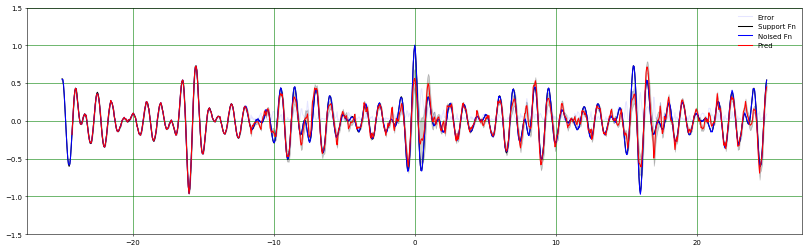

In [513]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 100.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           
           1.0 * ExpSineSquared( length_scale=1.0, periodicity=10.0,
                                length_scale_bounds=(0.1, 100.0),
                                periodicity_bounds=(1.0, 1000.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]
    
gp = GaussianProcessRegressor( kernel = kernels[ 2 ] + kernels[ 4 ], alpha=1e-10 )

gptstart = time.time()
gp.fit( 
    sampleData[ 0:int(percentageTraining*sampleData.shape[0]), : ], 
    sampleDataResponse[0:int(percentageTraining*sampleData.shape[0])] 
)
gptend = time.time()

gp_response, gp_std = gp.predict( sampleData, return_std=True )


print( "Nb of samples:", percentageTraining*sampleData.shape[0] )
print( "Time:", gptend-gptstart, "for training" )
print( "RMSE:", ( np.sum(( gp_response[ :, -1 ] - resp )**2) / resp.shape[ 0 ] )**0.5 )



fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
ax1.set_ylim( (-1.5, 1.5) )

ax1.plot( t[ windowSize + respOffset-1 + nbRespValues-1: ], np.abs(resp-gp_response[:, -1]), 'blue', label = 'Error', alpha = 0.1)

ax1.plot( t, fn, 'black', label = 'Support Fn' )
ax1.plot( t, nfn, 'blue', label = 'Noised Fn' )
ax1.plot( t[ windowSize+nbRespValues-1: ], gp_response[ :, nbRespValues-1 ], 'red', label = 'Pred' )


ax1.fill_between( t[ windowSize+nbRespValues-1: ], 
                 gp_response[ :, nbRespValues-1 ] - gp_std, 
                 gp_response[ :, nbRespValues-1 ] + gp_std,
                 alpha=0.2, color='k'
                )

ax1.legend(loc='upper right', frameon=False)

plt.show()


Nb of samples: 1983 ( 362 samples used for training )
Time: 0.537916898727417 ( 0.015867233276367188 for training )
RMSE: 0.08746357475078533
FRMSE: 0.05480518816968435


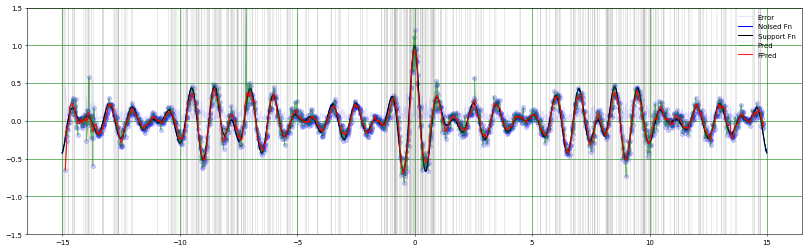

In [655]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import arange, pi

from scipy.signal import savgol_filter

%matplotlib inline 


# function range and actual values
t = arange( -15.0, 15.0, 0.015 )

fnA = np.cos( 2*pi*t ) * np.exp( -1.5*np.abs( np.abs( np.sin( 0.125*pi*t )) ) ) * np.cos( np.abs(t) )
fnB = np.cos( 1.0e-1*pi*t )

# single point of switching mix function (sigmoidal)
mixfnA = 1.0/(1.0+np.exp( -t ))
# multiple alternating switching points (sinusoid) 
mixfnB = (1+np.sin( 0.1*pi*t))/2
# first function ONLY (second function NOT used)
mixfnC = 1-t**0
# second function ONLY (first function NOT used)
mixfnD = t**0
# increasingly fast switching between the two functions
mixfnE = np.sin( 2*pi*(1e-1*t)**2 )

mixfn = mixfnE*(1-mixfnE)*mixfnA*(1-mixfnA)*mixfnE*(1-mixfnB)

fn = (1-mixfn)*fnA + mixfn*fnB



# variance for a normal noise applied to the function
sigma = 1.0e-2

# noised function (normal noise with sigma as specified above)
nfn = fn + sigma*np.random.randn( t.shape[ 0 ], )



# if running in 'adaptive' mode, a sample is used to update the model
# only if the absolute prediction error is above a specified threshold
adaptive = True
errorThreshold = 1.0e-1
# if adaptive mode is 'false' then a percentage of the samples is used
# for training (first percentage * nbSamples, cf. window 'scanner' below)
percentageTraining = 2.5e-1

# response values, actual vs predicted (lresp is for the learnt samples/responses)
resp = []; xresp = []; xlresp = [];
# index of the samples that were used as input for learning
lsindx = []



# index and size of the window we will use to scan the data; response offset w.r.t. window
nbTimeSteps = 3
indx = 0; windowSize = 2*nbTimeSteps-1; maxModelSamples = 75
windowPerturbation = 3; lastTstampOffset = 5; endingGap = lastTstampOffset + nbTimeSteps*windowPerturbation


# number of hidden units (rough ann simulation)
nbHUnits = 15
# initialize a matrix of randow weights (input-hidden layer)
rweights = np.random.randn( windowSize, nbHUnits )
# output weights (that need to be determined, first random)
oweights = np.random.randn( nbHUnits, 1 )



# ann svd for the output layer
annisvd = None


sampleData = None
sampleDataResponse = None



# counters and basic information (time spent training, nb. of samples, etc.)
startt = time.time()

trainingTime = 0
nbTrainingSamples = 0
nbSamples = 0

predTstamps = []

while indx < t.shape[ 0 ] - nbTimeSteps - endingGap:
    
    # generate a set of index values (cummulative sum, will be monotonically increasing)
    xindx = np.random.randint( 0, windowPerturbation, nbTimeSteps ).reshape( 1, nbTimeSteps )
    xindx = np.sort( xindx ); xindx = np.arange( indx, indx+nbTimeSteps ) + np.cumsum( xindx )
    # offset the last timestamp as to 'simulate' looking to a distant point
    xindx[ -1 ] = xindx[ -1 ] + lastTstampOffset
    
    # values and timestamps (from the noised function and the fixed-frequency timestamps)
    xvalues = nfn[ xindx ].reshape( nbTimeSteps, 1)
    #xtstamp = t[ xindx ].reshape( nbTimeSteps, 1 ) # TIMESTAMP
    xtstamp = (xindx-indx).reshape( nbTimeSteps, 1 ) # OFFSET
    #xtstamp[ 0 ] = t[ xtstamp[0]+indx ] # INSERT TIMESTAMP AT FIRST POSITION
    
    # construct a sample by stacking together the timestamp and the values
    xsample = np.hstack( (xtstamp, xvalues) ).reshape( 1, 2*nbTimeSteps )
    # drop the actual 'last' value from the sample (will be used as response)
    xsample = xsample[ :, :-1 ]
    
    # calculate the predicted value for the previously constructed sample
    xhlinp = np.dot( xsample, rweights )
    xhlinp = 1.0/( 1.0 + np.exp( -0.1*xhlinp ) ) - 0.5
        
    # predicted response
    xpresponse = np.dot( xhlinp.reshape( 1, nbHUnits ), oweights ).reshape( 1, )
    error = np.abs( xpresponse-xvalues[-1] )
    
    xresp = np.append( xresp, xpresponse[ -1 ] )
    resp  = np.append( resp, xvalues[ -1 ] )

    
    if sampleData is None:
        sampleData = xsample
        sampleDataResponse = xpresponse
    else:
        sampleData = np.vstack( (sampleData, xsample ) )
        sampleDataResponse = np.vstack( (sampleDataResponse, xpresponse) )
    
    
    
    #predTstamps = np.append( predTstamps, xtstamp[ -1 ] ) # TIMESTAMP
    predTstamps = np.append( predTstamps, t[ xindx[-1] ] ) # TIMESTAMP WHEN USING GAPS

            
    # no svd has been computed up to now, no prediction can be made
    if annisvd == None:
        
        X = xhlinp.reshape( nbHUnits, 1 )
        U, s, Vt = np.linalg.svd( X, full_matrices=False )
        
        annisvd = iSVD( U, s, Vt, updateVt = True  )        
        xlresp = [ xvalues[ -1 ] ]
        sampleAdded = True
                
    else:
        
        if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold):
            annisvd.update( xhlinp.reshape( nbHUnits, 1 ) )
            xlresp = np.vstack( (xlresp, xvalues[-1]) )                    
            
            if annisvd.Vt.shape[ 1 ] > maxModelSamples:
                try:
                    annisvd.downdate( 0 )
                    xlresp = xlresp[ 1:, : ]
                except:
                    print( "FAILED IN DOWNDATING VIA SVD")
                    
    # updating the output weights - note that the update method adds columns
    # and NOT rows (as it would be expected for Ax = y); the incremental SVD
    # we obtain is thus for A^T - we need however the A^+ (pseudoeinverse of A)
    
    # if A^T = UsV^T (SVD) and knowing that i. (A^T)+ = Vs^{-1}U^T; and (ii) (A^+)^T = (A^T)^+
    # we have that (A^+)^T = Vs^{-1}U^T, following that A^+ = Us^{-1}V^T
    
    # in order to upate the weights, we need to calculate x = A^+ y            
    
    if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold) :

        tstart = time.time()
        nbTrainingSamples = nbTrainingSamples+1

        Ux, sx, Vtx = annisvd.svd()

        nzindx = sx > 0; sx[ nzindx ] = 1.0/sx[ nzindx ]
        oweights = np.dot(
            np.dot( Ux, np.dot( np.diag( sx ), Vtx ) ),
            xlresp
        )
        
        tend = time.time()
        trainingTime = trainingTime + (tend-tstart)
        
        lsindx = np.append( lsindx, t[ indx ] )
    
    nbSamples = nbSamples+1
    indx = indx+1

endt = time.time()
    
print( "Nb of samples:", nbSamples, "(", nbTrainingSamples, "samples used for training )" )
print( "Time:", (endt-startt), "(", trainingTime, "for training )" )
print( "RMSE:", ( np.sum((xresp-resp)**2) / resp.shape[ 0 ] )**0.5 )

print( "FRMSE:", ( np.sum((savgol_filter( xresp, 51, 11, delta=0.015 )-resp)**2) / resp.shape[ 0 ] )**0.5 )


def axvlines(xs, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = plt.gca().get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = plt.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot


fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
ax1.set_ylim( (-1.5, 1.5) )

axvlines( lsindx, linewidth=0.5, color='gray', alpha=0.5 )

ax1.plot( predTstamps, np.abs(resp-xresp), 'blue', label = 'Error', alpha = 0.1)
ax1.plot( t, nfn, 'blue', label = 'Noised Fn' )
ax1.plot( t, fn, 'black', label = 'Support Fn') 


ax1.plot( predTstamps, xresp, 'green', label = 'Pred', alpha = 0.5 )
plt.scatter( predTstamps, xresp, color='blue', alpha = 0.2 )

ax1.plot( predTstamps, savgol_filter( xresp, 51, 11, delta=0.015 ), 'red', label = 'FPred', alpha = 0.9 )


ax1.legend(loc='upper right', frameon=False)

plt.show()

In [656]:
import gplearn as gpl
from gplearn import genetic

def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

        

    
# function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan', xexp ],

        
xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )

est_gpl = genetic.SymbolicRegressor(population_size=1000,
                           tournament_size=5,
                           function_set=['add', 'sub', 'mul', 'div', xexp ],
                           generations=35, stopping_criteria=0.01,
                           p_crossover=0.65, p_subtree_mutation=0.15,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=1.0, metric = 'rmse', verbose=1,
                           parsimony_coefficient=1e-3, random_state=None )

nbSamples = sampleData.shape[ 0 ]
indx = np.arange( 0, int(nbSamples*0.25), 1 )
est_gpl.fit( sampleData[ indx, : ], sampleDataResponse[ indx, -1 ] )

score_gpl = est_gpl.score( sampleData, sampleDataResponse[:,-1] )
pred_gpl = est_gpl.predict( sampleData )


print( "RMSE:", ( np.sum((pred_gpl-sampleDataResponse[:, -1])**2) / pred_gpl.shape[ 0 ] )**0.5 )
print( "FRMSE:", ( np.sum((savgol_filter( pred_gpl, 51, 11, delta=0.015 )-sampleDataResponse[:, -1])**2) / resp.shape[ 0 ] )**0.5 )


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    20.54 1.7680809167323503e+25        5 0.14145817947346231              N/A      1.54s
   1    12.83 91225431.87129745        1 0.1333414165457298              N/A      3.11s
   2    11.75 73163302.0237908        1 0.1333414165457298              N/A      2.38s
   3      7.0 3593103.856432818        5 0.10498985704287472              N/A      1.21s
   4     4.42 28780738.8001095        5 0.10498985704287472              N/A      0.00s
RMSE: 0.12149525248222078
FRMSE: 0.1329441921767261


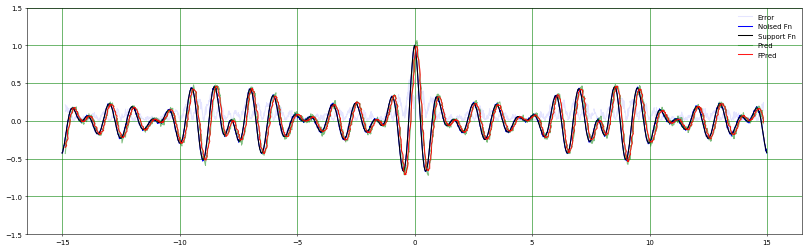

In [657]:
from scipy.signal import savgol_filter


fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
ax1.set_ylim( (-1.5, 1.5) )

ax1.plot( predTstamps, np.abs(resp-pred_gpl), 'blue', label = 'Error', alpha = 0.1)
ax1.plot( t, nfn, 'blue', label = 'Noised Fn' )
ax1.plot( t, fn, 'black', label = 'Support Fn') 


ax1.plot( predTstamps, pred_gpl, 'green', label = 'Pred', alpha = 0.5 )
ax1.plot( predTstamps, savgol_filter( pred_gpl, 65, 5, delta=0.015 ), 'red', label = 'FPred', alpha = 0.9 )

ax1.legend(loc='upper right', frameon=False)

plt.show()